In [53]:
import os
import xarray as xr
import matplotlib.pyplot as plt

In [54]:
raw_nc_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_raw/'
raw_nc_file = 'OOI-D20150817-T000000.nc'
Sv_nc_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_Sv_envFromFile/'
Sv_nc_file = 'OOI-D20150817-T000000_Sv.nc'

In [55]:
ds_raw = xr.open_dataset(os.path.join(raw_nc_path, raw_nc_file), group='Beam')
ds_Sv = xr.open_dataset(os.path.join(Sv_nc_path, Sv_nc_file))

In [56]:
# backscattering power (before calibration) unpacked from the .raw file
ds_raw['backscatter_r']

<xarray.DataArray 'backscatter_r' (frequency: 3, ping_time: 28718, range_bin: 1046)>
[90117084 values with dtype=float64]
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045

In [57]:
# calibrated Sv from echopype.EchoData.calibrate()
ds_Sv['Sv']

<xarray.DataArray 'Sv' (frequency: 3, ping_time: 28718, range_bin: 1046)>
[90117084 values with dtype=float64]
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045

## Calibration operation

The operations for calibrate are below (in `echopype.ek60.calibrate`):

```python
# Open data set for Environment and Beam groups
ds_beam = xr.open_dataset(self.file_path, group="Beam")

# Derived params
wavelength = self.sound_speed / ds_beam.frequency  # wavelength

# Get backscatter_r and range_bin pieces
backscatter_r = self.get_piece('backscatter_r')

# Calc gain
CSv = 10 * np.log10((ds_beam.transmit_power * (10 ** (ds_beam.gain_correction / 10)) ** 2 *
                     wavelength ** 2 * self.sound_speed * ds_beam.transmit_duration_nominal *
                     10 ** (ds_beam.equivalent_beam_angle / 10)) /
                    (32 * np.pi ** 2))

# Get TVG and absorption
range_meter = self.range
TVG = np.real(20 * np.log10(range_meter.where(range_meter >= 1, other=1)))
ABS = 2 * self.seawater_absorption * range_meter

# Calibration and echo integration
Sv = backscatter_r + TVG + ABS - CSv - 2 * ds_beam.sa_correction
```

## Comparion of raw and calibrated data

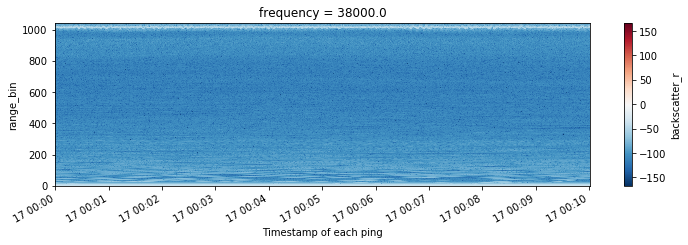

In [58]:
fig, ax = plt.subplots(figsize=(12,3))
ds_raw['backscatter_r'].sel(frequency=38000, 
                            ping_time=slice('2015-08-17T00:00:00','2015-08-17T00:10:00'))\
                       .plot(ax=ax, x='ping_time')
plt.show()

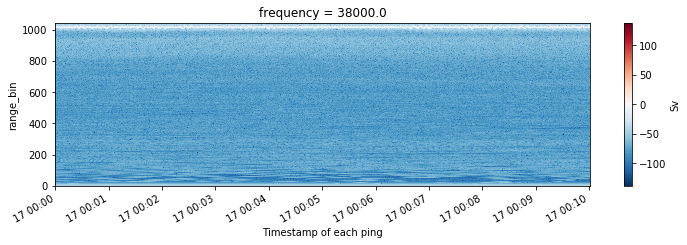

In [59]:
fig, ax = plt.subplots(figsize=(12,3))
ds_Sv['Sv'].sel(frequency=38000, 
                            ping_time=slice('2015-08-17T00:00:00','2015-08-17T00:10:00'))\
                       .plot(ax=ax, x='ping_time')
plt.show()

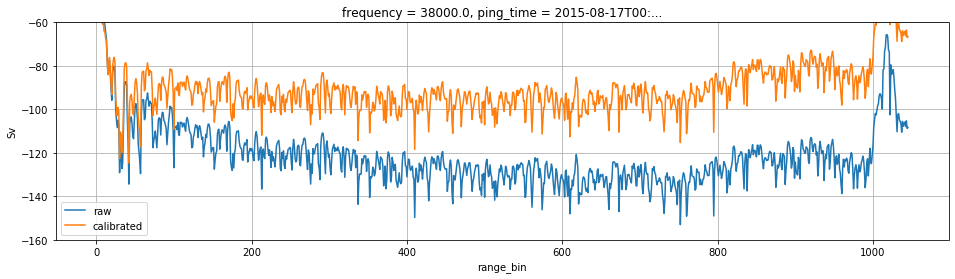

In [60]:
plt.figure(figsize=(16,4))
ds_raw['backscatter_r'].sel(frequency=38000).isel(ping_time=0).plot(label='raw')
ds_Sv['Sv'].sel(frequency=38000).isel(ping_time=0).plot(label='calibrated')
plt.ylim(-160,-60)
plt.grid()
plt.legend()
plt.show()